# Download CMIP6 4xCO2 data

This uses `netcdf-scm` to grab and process data.

See https://gitlab.com/netcdf-scm/netcdf-scm. This is based on one of the notebook examples.

Nicholls, Z, Lewis, J, Makin, M, et al. Regionally aggregated, stitched and de-drifted CMIP-climate data, processed with netCDF-SCM v2.0.0. Geosci Data J. 2021; 00: 1– 45. https://doi.org/10.1002/gdj3.113

In [1]:
from climateforcing.utils import mkdir_p
import netcdf_scm.io
import os
import glob
import requests
import zipfile
from tqdm import tqdm 
import scmdata
import matplotlib.pyplot as plt
import platform

In [2]:
platform.system()

'Darwin'

In [3]:
# file to save the downloaded zip in
ZIP_FILE = os.path.join("..", "data", "netcdf-scm", "4xCO2_data.zip")
ZIP_FILE

'../data/netcdf-scm/4xCO2_data.zip'

In [4]:
# directory in which to extract data
DATA_DIR = os.path.join("..", "data", "netcdf-scm", "cmip_data")
mkdir_p(DATA_DIR)

In [5]:
# from https://stackoverflow.com/questions/40419395/python-zipfile-extractall-ioerror-on-windows-when-extracting-files-from-long-pat
class ZipfileLongPaths(zipfile.ZipFile):

    def _extract_member(self, member, targetpath, pwd):
        targetpath = winapi_path(targetpath)
        return zipfile.ZipFile._extract_member(self, member, targetpath, pwd)
    
    
def winapi_path(dos_path, encoding=None):
    path = os.path.abspath(dos_path)
    if platform.system() == "Windows":
        if path.startswith("\\\\"):
            path = "\\\\?\\UNC\\" + path[2:]
        else:
            path = "\\\\?\\" + path 
    return path  

In [6]:
experiments = (
    "abrupt-4xCO2",
)
variables = (
    "tas",
    "rsdt",
    "rsut",
    "rlut",
)

for exp in experiments:
    for var in variables:
        print(f"Downloading {exp} {var}")
        params = (
            ("experiment_id", exp),
            ("variable_id", var),
            ("timeseriestype", "average-year-mid-year"),
            ("normalised", "21-yr-running-mean"),
        )
        url = "https://cmip6.science.unimelb.edu.au/api/v1/download_zip"

        r = requests.get(url, params=params)
        r.raise_for_status()

        with open(ZIP_FILE, "wb") as f:
            f.write(r.content)

        zip_ref = ZipfileLongPaths(ZIP_FILE, "r")
        zip_ref.extractall(DATA_DIR)
        zip_ref.close()

print("Finished")

Finished


In [7]:
available_files = glob.glob(winapi_path(os.path.join(DATA_DIR, "**", "abrupt-4xCO2", "**", "*.MAG")), recursive=True)
print(f"{len(available_files)} available files")
available_files[:5]

174 available files


['/Users/chris/git/chrisroadmap/fair2.1-calibrate/data/netcdf-scm/cmip_data/average-year-mid-year/CMIP6/CMIP/CAS/FGOALS-g3/abrupt-4xCO2/r1i1p1f1/Amon/rlut/gn/v20191230/NORMED_netcdf-scm_rlut_Amon_FGOALS-g3_abrupt-4xCO2_r1i1p1f1_gn_0463-0614.MAG',
 '/Users/chris/git/chrisroadmap/fair2.1-calibrate/data/netcdf-scm/cmip_data/average-year-mid-year/CMIP6/CMIP/CAS/FGOALS-g3/abrupt-4xCO2/r1i1p1f1/Amon/rsut/gn/v20191230/NORMED_netcdf-scm_rsut_Amon_FGOALS-g3_abrupt-4xCO2_r1i1p1f1_gn_0463-0614.MAG',
 '/Users/chris/git/chrisroadmap/fair2.1-calibrate/data/netcdf-scm/cmip_data/average-year-mid-year/CMIP6/CMIP/CAS/FGOALS-g3/abrupt-4xCO2/r1i1p1f1/Amon/rsdt/gn/v20191230/NORMED_netcdf-scm_rsdt_Amon_FGOALS-g3_abrupt-4xCO2_r1i1p1f1_gn_0463-0614.MAG',
 '/Users/chris/git/chrisroadmap/fair2.1-calibrate/data/netcdf-scm/cmip_data/average-year-mid-year/CMIP6/CMIP/CAS/FGOALS-g3/abrupt-4xCO2/r1i1p1f1/Amon/tas/gn/v20191230/NORMED_netcdf-scm_tas_Amon_FGOALS-g3_abrupt-4xCO2_r1i1p1f1_gn_0463-0614.MAG',
 '/Users/chris

In [8]:
db = [
    netcdf_scm.io.load_mag_file(f, "CMIP6Output")
    for f in tqdm(available_files, position=0, leave=True)
]

100%|█████████████████████████████████████████| 174/174 [00:11<00:00, 14.53it/s]


In [9]:
db = scmdata.run_append(db).filter(region="World")
db.head()

time                                                                                         0001-07-01 00:00:00  \
activity_id climate_model member_id mip_era model       region scenario     unit   variable                        
CMIP        FGOALS-g3     r1i1p1f1  CMIP6   unspecified World  abrupt-4xCO2 W m^-2 rlut                      NaN   
                                                                                   rsut                      NaN   
                                                                                   rsdt                      NaN   
                                                                            K      tas                       NaN   
            E3SM-1-0      r1i1p1f1  CMIP6   unspecified World  abrupt-4xCO2 W m^-2 rlut                 -4.76337   

time                                                                                         0002-07-01 00:00:00  \
activity_id climate_model member_id mip_era model       region scenario     unit   variable                        
CMIP        FGOALS-g3     r1i1p1f1  CMIP6   unspecified World  abrupt-4xCO2 W m^-2 rlut                      NaN   
                                                                                   rsut                      NaN   
                                                                                   rsdt                      NaN   
                                                                            K      tas                       NaN   
            E3SM-1-0      r1i1p1f1  CMIP6   unspecified World  abrupt-4xCO2 W m^-2 rlut                 -3.10792   

time                                                                                         0003-07-01 00:00:00  \
activity_id climate_model member_id mip_era model       region scenario     unit   variable                        
CMIP        FGOALS-g3     r1i1p1f1  CMIP6   unspecified World  abrupt-4xCO2 W m^-2 rlut                      NaN   
                                                                                   rsut                      NaN   
                                                                                   rsdt                      NaN   
                                                                            K      tas                       NaN   
            E3SM-1-0      r1i1p1f1  CMIP6   unspecified World  abrupt-4xCO2 W m^-2 rlut                 -2.21684   

time                                                                                         0004-07-01 00:00:00  \
activity_id climate_model member_id mip_era model       region scenario     unit   variable                        
CMIP        FGOALS-g3     r1i1p1f1  CMIP6   unspecified World  abrupt-4xCO2 W m^-2 rlut                      NaN   
                                                                                   rsut                      NaN   
                                                                                   rsdt                      NaN   
                                                                            K      tas                       NaN   
            E3SM-1-0      r1i1p1f1  CMIP6   unspecified World  abrupt-4xCO2 W m^-2 rlut                  -1.3575   

time                                                                                         0005-07-01 00:00:00  \
activity_id climate_model member_id mip_era model       region scenario     unit   variable                        
CMIP        FGOALS-g3     r1i1p1f1  CMIP6   unspecified World  abrupt-4xCO2 W m^-2 rlut                      NaN   
                                                                                   rsut                      NaN   
                                                                                   rsdt                      NaN   
                                                                            K      tas                       NaN   
            E3SM-1-0      r1i1p1f1  CMIP6   unspecif

In [10]:
required_vars = {"tas", "rlut", "rsut", "rsdt"}
force_first_year = 1850

out = []
for scdf in tqdm(db.groupby(["climate_model", "member_id", "scenario"]), position=0, leave=True):
    climate_model = scdf.get_unique_meta("climate_model", True)
    scenario = scdf.get_unique_meta("scenario", True)
    member_id = scdf.get_unique_meta("member_id", True)
    available_vars = scdf["variable"].unique()
    if not all([v in available_vars for v in required_vars]):
        print(f"Not all required data for {climate_model} {member_id} {scenario}")
        print("Available vars: {}".format(available_vars))
        continue

    rndt = (
        scdf.filter(variable="rsdt")
        .subtract(scdf.filter(variable="rsut"), op_cols={"variable": "rsdt - rsut"})
        .subtract(scdf.filter(variable="rlut"), op_cols={"variable": "rndt"})
    )

    keep = scmdata.run_append([scdf, rndt]).timeseries(
        time_axis="year", drop_all_nan_times=True
    )
    
    if keep.shape[1]<150:
        print(f"Time series is too short in {climate_model} {member_id} {scenario}")
        continue
    
    first_year = keep.columns[0]
    keep.columns = keep.columns.map(lambda x: force_first_year + x - first_year)

    out.append(scmdata.ScmRun(keep))

out = scmdata.run_append(out)
out.head()

19it [00:06,  2.10it/s]

Not all required data for FIO-ESM-2-0 r1i1p1f1 abrupt-4xCO2
Available vars: ['tas']
Not all required data for FIO-ESM-2-0 r2i1p1f1 abrupt-4xCO2
Available vars: ['tas']
Not all required data for FIO-ESM-2-0 r3i1p1f1 abrupt-4xCO2
Available vars: ['tas']


25it [00:08,  3.01it/s]

Time series is too short in GISS-E2-1-G r1i1p1f3 abrupt-4xCO2


34it [00:12,  2.31it/s]

Not all required data for MPI-ESM-1-2-HAM r1i1p1f1 abrupt-4xCO2
Available vars: ['rlut' 'rsdt' 'tas']


44it [00:15,  3.18it/s]

Not all required data for NorESM2-MM r1i1p1f1 abrupt-4xCO2
Available vars: ['rlut' 'rsut' 'rsdt']


47it [00:15,  2.94it/s]


Not all required data for UKESM1-0-LL r1i1p1f2 abrupt-4xCO2
Available vars: ['rsut']


time                                                                                                    1850-01-01  \
activity_id climate_model member_id mip_era model       region scenario     unit              variable               
CMIP        ACCESS-CM2    r1i1p1f1  CMIP6   unspecified World  abrupt-4xCO2 W m^-2            rlut       -4.186300   
                                                                                              rsut       -3.379800   
                                                                                              rsdt       -0.001992   
                                                                            K                 tas         1.032890   
                                                                            watt / meter ** 2 rndt        7.564108   

time                                                                                                    1851-01-01  \
activity_id climate_model member_id mip_era model       region scenario     unit              variable               
CMIP        ACCESS-CM2    r1i1p1f1  CMIP6   unspecified World  abrupt-4xCO2 W m^-2            rlut       -1.662220   
                                                                                              rsut       -4.525210   
                                                                                              rsdt       -0.001992   
                                                                            K                 tas         1.981440   
                                                                            watt / meter ** 2 rndt        6.185438   

time                                                                                                    1852-01-01  \
activity_id climate_model member_id mip_era model       region scenario     unit              variable               
CMIP        ACCESS-CM2    r1i1p1f1  CMIP6   unspecified World  abrupt-4xCO2 W m^-2            rlut       -0.829526   
                                                                                              rsut       -4.601540   
                                                                                              rsdt        0.006375   
                                                                            K                 tas         2.296340   
                                                                            watt / meter ** 2 rndt        5.437441   

time                                                                                                    1853-01-01  \
activity_id climate_model member_id mip_era model       region scenario     unit              variable               
CMIP        ACCESS-CM2    r1i1p1f1  CMIP6   unspecified World  abrupt-4xCO2 W m^-2            rlut        0.402468   
                                                                                              rsut       -4.945020   
                                                                                              rsdt       -0.001992   
                                                                            K                 tas         2.724370   
                                                                            watt / meter ** 2 rndt        4.540560   

time                                                                                                    1854-01-01  \
activity_id climate_model member_id mip_era model       region scenario     unit              variable               
CMIP        ACCESS-CM2    r1i1p1f1  CMIP6   unspecified World  abrupt-4xCO2 W m^-2            rlut        0.243253   
                                                                                              rsut       -5.472330   
                                                                                              rsdt       -0.001992   
                                                                            K                 tas     

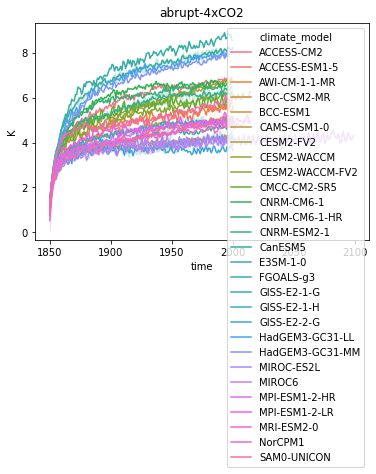

In [11]:
for sdf in out.groupby("scenario"):
    scenario = sdf.get_unique_meta("scenario", True)
    ax = sdf.filter(variable="tas").lineplot(hue="climate_model", time_axis="year")
    ax.set_title(scenario)
    plt.show()

In [12]:
out

<scmdata.ScmRun (timeseries: 200, timepoints: 250)>
Time:
	Start: 1850-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	    activity_id climate_model member_id mip_era        model region  \
	0          CMIP    ACCESS-CM2  r1i1p1f1   CMIP6  unspecified  World   
	1          CMIP    ACCESS-CM2  r1i1p1f1   CMIP6  unspecified  World   
	2          CMIP    ACCESS-CM2  r1i1p1f1   CMIP6  unspecified  World   
	3          CMIP    ACCESS-CM2  r1i1p1f1   CMIP6  unspecified  World   
	4          CMIP    ACCESS-CM2  r1i1p1f1   CMIP6  unspecified  World   
	..          ...           ...       ...     ...          ...    ...   
	195        CMIP   SAM0-UNICON  r1i1p1f1   CMIP6  unspecified  World   
	196        CMIP   SAM0-UNICON  r1i1p1f1   CMIP6  unspecified  World   
	197        CMIP   SAM0-UNICON  r1i1p1f1   CMIP6  unspecified  World   
	198        CMIP   SAM0-UNICON  r1i1p1f1   CMIP6  unspecified  World   
	199        CMIP   SAM0-UNICON  r1i1p1f1   CMIP6  unspecified  World   
	
	         scenar

In [13]:
out.to_csv(os.path.join("..", "data", "netcdf-scm", "4xCO2.csv"))